# Importar Librerías Necesarias
Importar las librerías requeridas como TensorFlow, NumPy, Matplotlib, y otras necesarias para el procesamiento de datos y el entrenamiento del modelo.

In [1]:
# Importar las librerías necesarias
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re
import cv2
from pathlib import Path

# Configuración para mostrar gráficos en el notebook
%matplotlib inline

# Definir Constantes y Funciones Auxiliares
Definir constantes como IMG_HEIGHT, IMG_WIDTH, CHARS, y funciones auxiliares como cargar_datos y preprocesar_etiquetas.

In [2]:
# Definir constantes
IMG_HEIGHT = 100
IMG_WIDTH = 280
BATCH_SIZE = 32
EPOCHS = 30
CHARS = "0123456789 BCDFGHJKLMNPQRSTVWXYZ"  # Caracteres permitidos (dígitos + espacio + letras sin vocales)
CHAR_TO_INDEX = {char: idx for idx, char in enumerate(CHARS)}
INDEX_TO_CHAR = {idx: char for idx, char in enumerate(CHARS)}
MAX_LENGTH = 8  # 4 dígitos + 1 espacio + 3 letras

# Función para cargar datos
def cargar_datos(data_dir="dades"):
    """Carga las imágenes y sus correspondientes etiquetas."""
    print("Cargando datos...")
    data_path = os.path.join(os.getcwd(), data_dir)
    
    if not os.path.exists(data_path):
        raise FileNotFoundError(f"No se encuentra el directorio de datos: {data_path}")
    
    images = []
    labels = []
    pattern = r"matricula_([0-9]{4}\s[A-Z]{3})_\d+\.jpg"
    
    for img_file in os.listdir(data_path):
        if img_file.endswith('.jpg'):
            match = re.match(pattern, img_file)
            if match:
                plate_text = match.group(1)
                img_path = os.path.join(data_path, img_file)
                img = load_img(img_path, color_mode="grayscale", target_size=(IMG_HEIGHT, IMG_WIDTH))
                img = img_to_array(img) / 255.0  # Normalizar a [0,1]
                images.append(img)
                labels.append(plate_text)
    
    print(f"Se han cargado {len(images)} imágenes con sus etiquetas.")
    return np.array(images), np.array(labels)

# Función para preprocesar etiquetas
def preprocesar_etiquetas(labels):
    """Convierte las etiquetas de texto a formato one-hot para secuencias."""
    y = np.zeros((len(labels), MAX_LENGTH, len(CHARS)), dtype=np.float32)
    for i, label in enumerate(labels):
        for j, char in enumerate(label):
            if j < MAX_LENGTH and char in CHAR_TO_INDEX:
                y[i, j, CHAR_TO_INDEX[char]] = 1.0
    return y

# Cargar y Preprocesar Datos
Cargar las imágenes y etiquetas desde el directorio de datos, preprocesarlas y dividirlas en conjuntos de entrenamiento, validación y prueba.

In [3]:
# Cargar y preprocesar los datos
# Cargar las imágenes y etiquetas
X, y_text = cargar_datos(data_dir="dades")

# Preprocesar las etiquetas en formato one-hot
y = preprocesar_etiquetas(y_text)

# Dividir los datos en conjuntos de entrenamiento, validación y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Mostrar las dimensiones de los conjuntos de datos
print(f"Datos de entrenamiento: {X_train.shape}")
print(f"Datos de validación: {X_val.shape}")
print(f"Datos de prueba: {X_test.shape}")

Cargando datos...
Se han cargado 50 imágenes con sus etiquetas.
Datos de entrenamiento: (32, 100, 280, 1)
Datos de validación: (8, 100, 280, 1)
Datos de prueba: (10, 100, 280, 1)


# Crear el Modelo OCR
Definir la arquitectura del modelo OCR utilizando capas de TensorFlow, incluyendo convoluciones, densas y salidas para cada carácter.

In [4]:
# Definir la arquitectura del modelo OCR
def crear_modelo():
    """Crea un modelo CNN para OCR."""
    # Entrada
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))
    
    # Convoluciones
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Reshape para LSTM - Arreglando el problema de dimensionalidad
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    
    # Dividir las características para cada posición de carácter
    outputs = []
    for i in range(MAX_LENGTH):
        char_output = layers.Dense(64, activation='relu')(x)
        char_output = layers.Dense(len(CHARS), activation='softmax', name=f'char_{i}')(char_output)
        outputs.append(char_output)
    
    # Crear el modelo
    model = models.Model(inputs=inputs, outputs=outputs)
    
    # Definir las pérdidas y métricas para cada salida
    losses = {f'char_{i}': 'categorical_crossentropy' for i in range(MAX_LENGTH)}
    metrics = {f'char_{i}': 'accuracy' for i in range(MAX_LENGTH)}
    
    # Compilar el modelo
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss=losses,
        metrics=metrics
    )
    
    return model

# Crear el modelo
model = crear_modelo()

# Mostrar el resumen del modelo
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 280,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 100, 280,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 50, 140,   │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 50, 140,   │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 25, 70,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 25, 70,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 12, 35,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 12, 35,    │    147,584 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 6, 17,     │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 13056)     │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  6,685,184 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     32,832 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     32,832 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │     32,832 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │     32,832 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │     32,832 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │     32,832 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │     32,832 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │     32,832 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 7,204,736 (27.48 MB)

 Trainable params: 7,204,736 (27.48 MB)

 Non-trainable params: 0 (0.00 B)

# Entrenar el Modelo
Entrenar el modelo utilizando los datos de entrenamiento y validación, con callbacks para guardar el mejor modelo y aplicar early stopping.

In [5]:
# Entrenar el modelo
# Preparar las etiquetas para cada salida
y_train_outputs = [y_train[:, i, :] for i in range(MAX_LENGTH)]
y_val_outputs = [y_val[:, i, :] for i in range(MAX_LENGTH)]

# Definir callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "mejor_modelo_ocr.h5",
    monitor='val_loss',
    save_best_only=True
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Entrenar el modelo
history = model.fit(
    X_train, y_train_outputs,
    validation_data=(X_val, y_val_outputs),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - char_0_accuracy: 0.0000e+00 - char_0_loss: 3.4936 - char_1_accuracy: 0.0312 - char_1_loss: 3.4491 - char_2_accuracy: 0.1562 - char_2_loss: 3.4345 - char_3_accuracy: 0.0000e+00 - char_3_loss: 3.4630 - char_4_accuracy: 0.0000e+00 - char_4_loss: 3.5129 - char_5_accuracy: 0.0625 - char_5_loss: 3.4368 - char_6_accuracy: 0.0000e+00 - char_6_loss: 3.5107 - char_7_accuracy: 0.0000e+00 - char_7_loss: 3.4918 - loss: 27.7924

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - char_0_accuracy: 0.0000e+00 - char_0_loss: 3.4936 - char_1_accuracy: 0.0312 - char_1_loss: 3.4491 - char_2_accuracy: 0.1562 - char_2_loss: 3.4345 - char_3_accuracy: 0.0000e+00 - char_3_loss: 3.4630 - char_4_accuracy: 0.0000e+00 - char_4_loss: 3.5129 - char_5_accuracy: 0.0625 - char_5_loss: 3.4368 - char_6_accuracy: 0.0000e+00 - char_6_loss: 3.5107 - char_7_accuracy: 0.0000e+00 - char_7_loss: 3.4918 - loss: 27.7924 - val_char_0_accuracy: 0.3750 - val_char_0_loss: 3.0950 - val_char_1_accuracy: 0.0000e+00 - val_char_1_loss: 3.1483 - val_char_2_accuracy: 0.1250 - val_char_2_loss: 3.2956 - val_char_3_accuracy: 0.1250 - val_char_3_loss: 3.1977 - val_char_4_accuracy: 1.0000 - val_char_4_loss: 1.9815 - val_char_5_accuracy: 0.0000e+00 - val_char_5_loss: 3.2976 - val_char_6_accuracy: 0.0000e+00 - val_char_6_loss: 3.1771 - val_char_7_accuracy: 0.0000e+00 - val_char_7_loss: 3.5995 - val_loss: 24.7923
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - char_0_a

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - char_0_accuracy: 0.2812 - char_0_loss: 3.1829 - char_1_accuracy: 0.0625 - char_1_loss: 3.2714 - char_2_accuracy: 0.1562 - char_2_loss: 3.1412 - char_3_accuracy: 0.0000e+00 - char_3_loss: 3.3181 - char_4_accuracy: 1.0000 - char_4_loss: 1.9849 - char_5_accuracy: 0.0312 - char_5_loss: 3.3282 - char_6_accuracy: 0.0312 - char_6_loss: 3.2399 - char_7_accuracy: 0.0000e+00 - char_7_loss: 3.4903 - loss: 24.9568 - val_char_0_accuracy: 0.3750 - val_char_0_loss: 2.9902 - val_char_1_accuracy: 0.3750 - val_char_1_loss: 2.3331 - val_char_2_accuracy: 0.1250 - val_char_2_loss: 3.4670 - val_char_3_accuracy: 0.3750 - val_char_3_loss: 2.7708 - val_char_4_accuracy: 1.0000 - val_char_4_loss: 0.0677 - val_char_5_accuracy: 0.1250 - val_char_5_loss: 3.0650 - val_char_6_accuracy: 0.3750 - val_char_6_loss: 2.2842 - val_char_7_accuracy: 0.0000e+00 - val_char_7_loss: 3.5679 - val_loss: 20.5460
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - char_0_accuracy: 0.2812 - cha

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - char_0_accuracy: 0.2812 - char_0_loss: 3.2630 - char_1_accuracy: 0.1562 - char_1_loss: 2.9671 - char_2_accuracy: 0.1250 - char_2_loss: 2.9581 - char_3_accuracy: 0.1250 - char_3_loss: 3.3862 - char_4_accuracy: 1.0000 - char_4_loss: 0.0915 - char_5_accuracy: 0.1562 - char_5_loss: 3.4235 - char_6_accuracy: 0.2188 - char_6_loss: 2.9509 - char_7_accuracy: 0.0000e+00 - char_7_loss: 3.3814 - loss: 22.4216 - val_char_0_accuracy: 0.2500 - val_char_0_loss: 2.9136 - val_char_1_accuracy: 0.3750 - val_char_1_loss: 2.2305 - val_char_2_accuracy: 0.1250 - val_char_2_loss: 2.9138 - val_char_3_accuracy: 0.3750 - val_char_3_loss: 2.5098 - val_char_4_accuracy: 1.0000 - val_char_4_loss: 0.0617 - val_char_5_accuracy: 0.1250 - val_char_5_loss: 2.9865 - val_char_6_accuracy: 0.3750 - val_char_6_loss: 2.2482 - val_char_7_accuracy: 0.0000e+00 - val_char_7_loss: 3.1949 - val_loss: 19.0590
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - char_0_accuracy: 0.1562 - char_0_

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - char_0_accuracy: 0.1562 - char_0_loss: 2.8057 - char_1_accuracy: 0.3438 - char_1_loss: 2.7028 - char_2_accuracy: 0.1875 - char_2_loss: 2.6637 - char_3_accuracy: 0.2812 - char_3_loss: 2.8156 - char_4_accuracy: 1.0000 - char_4_loss: 0.0870 - char_5_accuracy: 0.0938 - char_5_loss: 3.2200 - char_6_accuracy: 0.2188 - char_6_loss: 2.6914 - char_7_accuracy: 0.0938 - char_7_loss: 3.0575 - loss: 20.0437 - val_char_0_accuracy: 0.2500 - val_char_0_loss: 2.8291 - val_char_1_accuracy: 0.3750 - val_char_1_loss: 2.2406 - val_char_2_accuracy: 0.1250 - val_char_2_loss: 2.7358 - val_char_3_accuracy: 0.3750 - val_char_3_loss: 2.4349 - val_char_4_accuracy: 1.0000 - val_char_4_loss: 0.0581 - val_char_5_accuracy: 0.0000e+00 - val_char_5_loss: 2.9079 - val_char_6_accuracy: 0.3750 - val_char_6_loss: 2.3693 - val_char_7_accuracy: 0.0000e+00 - val_char_7_loss: 3.0345 - val_loss: 18.6102
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - char_0_accuracy: 0.2188 - char_0_

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - char_0_accuracy: 0.2188 - char_0_loss: 2.8146 - char_1_accuracy: 0.3438 - char_1_loss: 2.6455 - char_2_accuracy: 0.3125 - char_2_loss: 2.5041 - char_3_accuracy: 0.3125 - char_3_loss: 2.6523 - char_4_accuracy: 1.0000 - char_4_loss: 0.0831 - char_5_accuracy: 0.0938 - char_5_loss: 2.9679 - char_6_accuracy: 0.1250 - char_6_loss: 2.7384 - char_7_accuracy: 0.1250 - char_7_loss: 2.9150 - loss: 19.3209 - val_char_0_accuracy: 0.2500 - val_char_0_loss: 2.6660 - val_char_1_accuracy: 0.3750 - val_char_1_loss: 2.1573 - val_char_2_accuracy: 0.1250 - val_char_2_loss: 2.6271 - val_char_3_accuracy: 0.3750 - val_char_3_loss: 2.2877 - val_char_4_accuracy: 1.0000 - val_char_4_loss: 0.0230 - val_char_5_accuracy: 0.0000e+00 - val_char_5_loss: 2.8220 - val_char_6_accuracy: 0.0000e+00 - val_char_6_loss: 2.3493 - val_char_7_accuracy: 0.0000e+00 - val_char_7_loss: 2.8211 - val_loss: 17.7534
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - char_0_accuracy: 0.2188 - cha

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - char_0_accuracy: 0.2188 - char_0_loss: 2.7394 - char_1_accuracy: 0.3438 - char_1_loss: 2.5313 - char_2_accuracy: 0.1875 - char_2_loss: 2.4994 - char_3_accuracy: 0.2812 - char_3_loss: 2.5156 - char_4_accuracy: 1.0000 - char_4_loss: 0.0273 - char_5_accuracy: 0.0938 - char_5_loss: 3.0294 - char_6_accuracy: 0.0938 - char_6_loss: 2.6887 - char_7_accuracy: 0.0938 - char_7_loss: 2.6632 - loss: 18.6943 - val_char_0_accuracy: 0.1250 - val_char_0_loss: 2.5368 - val_char_1_accuracy: 0.3750 - val_char_1_loss: 2.0588 - val_char_2_accuracy: 0.1250 - val_char_2_loss: 2.5455 - val_char_3_accuracy: 0.3750 - val_char_3_loss: 2.1557 - val_char_4_accuracy: 1.0000 - val_char_4_loss: 0.0073 - val_char_5_accuracy: 0.0000e+00 - val_char_5_loss: 2.7257 - val_char_6_accuracy: 0.0000e+00 - val_char_6_loss: 2.2528 - val_char_7_accuracy: 0.0000e+00 - val_char_7_loss: 2.6235 - val_loss: 16.9061
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - char_0_accuracy: 0.0938 - cha

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - char_0_accuracy: 0.0938 - char_0_loss: 2.5454 - char_1_accuracy: 0.3750 - char_1_loss: 2.4835 - char_2_accuracy: 0.2188 - char_2_loss: 2.3001 - char_3_accuracy: 0.2188 - char_3_loss: 2.4015 - char_4_accuracy: 1.0000 - char_4_loss: 0.0114 - char_5_accuracy: 0.2188 - char_5_loss: 2.9095 - char_6_accuracy: 0.2500 - char_6_loss: 2.3673 - char_7_accuracy: 0.2812 - char_7_loss: 2.4087 - loss: 17.4273 - val_char_0_accuracy: 0.1250 - val_char_0_loss: 2.4739 - val_char_1_accuracy: 0.3750 - val_char_1_loss: 1.8962 - val_char_2_accuracy: 0.1250 - val_char_2_loss: 2.4475 - val_char_3_accuracy: 0.3750 - val_char_3_loss: 2.0651 - val_char_4_accuracy: 1.0000 - val_char_4_loss: 0.0020 - val_char_5_accuracy: 0.0000e+00 - val_char_5_loss: 2.6475 - val_char_6_accuracy: 0.3750 - val_char_6_loss: 2.1545 - val_char_7_accuracy: 0.3750 - val_char_7_loss: 2.5015 - val_loss: 16.1881
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - char_0_accuracy: 0.1250 - char_0_loss

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - char_0_accuracy: 0.1250 - char_0_loss: 2.5292 - char_1_accuracy: 0.3750 - char_1_loss: 2.3298 - char_2_accuracy: 0.0938 - char_2_loss: 2.4376 - char_3_accuracy: 0.3125 - char_3_loss: 2.2741 - char_4_accuracy: 1.0000 - char_4_loss: 0.0037 - char_5_accuracy: 0.0312 - char_5_loss: 2.9129 - char_6_accuracy: 0.2500 - char_6_loss: 2.1149 - char_7_accuracy: 0.2188 - char_7_loss: 2.2290 - loss: 16.8313 - val_char_0_accuracy: 0.3750 - val_char_0_loss: 2.3984 - val_char_1_accuracy: 0.3750 - val_char_1_loss: 1.7505 - val_char_2_accuracy: 0.1250 - val_char_2_loss: 2.3174 - val_char_3_accuracy: 0.3750 - val_char_3_loss: 2.0566 - val_char_4_accuracy: 1.0000 - val_char_4_loss: 0.0012 - val_char_5_accuracy: 0.1250 - val_char_5_loss: 2.5743 - val_char_6_accuracy: 0.3750 - val_char_6_loss: 2.1096 - val_char_7_accuracy: 0.0000e+00 - val_char_7_loss: 2.4410 - val_loss: 15.6490
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - char_0_accuracy: 0.3438 - char_0_loss

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - char_0_accuracy: 0.3438 - char_0_loss: 2.2799 - char_1_accuracy: 0.2500 - char_1_loss: 2.2890 - char_2_accuracy: 0.3125 - char_2_loss: 2.2547 - char_3_accuracy: 0.2812 - char_3_loss: 2.0265 - char_4_accuracy: 1.0000 - char_4_loss: 0.0013 - char_5_accuracy: 0.1250 - char_5_loss: 2.8260 - char_6_accuracy: 0.2812 - char_6_loss: 2.3280 - char_7_accuracy: 0.1875 - char_7_loss: 2.3458 - loss: 16.3513 - val_char_0_accuracy: 0.3750 - val_char_0_loss: 2.3011 - val_char_1_accuracy: 0.3750 - val_char_1_loss: 1.6886 - val_char_2_accuracy: 0.1250 - val_char_2_loss: 2.1926 - val_char_3_accuracy: 0.3750 - val_char_3_loss: 2.0486 - val_char_4_accuracy: 1.0000 - val_char_4_loss: 0.0013 - val_char_5_accuracy: 0.1250 - val_char_5_loss: 2.5523 - val_char_6_accuracy: 0.3750 - val_char_6_loss: 2.1084 - val_char_7_accuracy: 0.3750 - val_char_7_loss: 2.3626 - val_loss: 15.2554
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - char_0_accuracy: 0.3125 - char_0_loss: 2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - char_0_accuracy: 0.3125 - char_0_loss: 2.1752 - char_1_accuracy: 0.3750 - char_1_loss: 2.1873 - char_2_accuracy: 0.2188 - char_2_loss: 2.0953 - char_3_accuracy: 0.2188 - char_3_loss: 2.1567 - char_4_accuracy: 1.0000 - char_4_loss: 0.0024 - char_5_accuracy: 0.2188 - char_5_loss: 2.7188 - char_6_accuracy: 0.2500 - char_6_loss: 2.3548 - char_7_accuracy: 0.1250 - char_7_loss: 2.3040 - loss: 15.9947 - val_char_0_accuracy: 0.3750 - val_char_0_loss: 2.2433 - val_char_1_accuracy: 0.3750 - val_char_1_loss: 1.6631 - val_char_2_accuracy: 0.2500 - val_char_2_loss: 2.1072 - val_char_3_accuracy: 0.3750 - val_char_3_loss: 2.0254 - val_char_4_accuracy: 1.0000 - val_char_4_loss: 0.0012 - val_char_5_accuracy: 0.1250 - val_char_5_loss: 2.5411 - val_char_6_accuracy: 0.3750 - val_char_6_loss: 2.1213 - val_char_7_accuracy: 0.3750 - val_char_7_loss: 2.2895 - val_loss: 14.9922
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - char_0_accuracy: 0.2500 - char_0_loss: 2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - char_0_accuracy: 0.2500 - char_0_loss: 2.1980 - char_1_accuracy: 0.2812 - char_1_loss: 2.2088 - char_2_accuracy: 0.1562 - char_2_loss: 2.0894 - char_3_accuracy: 0.3438 - char_3_loss: 2.1350 - char_4_accuracy: 1.0000 - char_4_loss: 0.0027 - char_5_accuracy: 0.0938 - char_5_loss: 2.7019 - char_6_accuracy: 0.2500 - char_6_loss: 2.1259 - char_7_accuracy: 0.1250 - char_7_loss: 2.1455 - loss: 15.6071 - val_char_0_accuracy: 0.3750 - val_char_0_loss: 2.2084 - val_char_1_accuracy: 0.3750 - val_char_1_loss: 1.5920 - val_char_2_accuracy: 0.2500 - val_char_2_loss: 2.0338 - val_char_3_accuracy: 0.3750 - val_char_3_loss: 1.9724 - val_char_4_accuracy: 1.0000 - val_char_4_loss: 5.7766e-04 - val_char_5_accuracy: 0.1250 - val_char_5_loss: 2.5332 - val_char_6_accuracy: 0.3750 - val_char_6_loss: 2.0959 - val_char_7_accuracy: 0.3750 - val_char_7_loss: 2.2070 - val_loss: 14.6433
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - char_0_accuracy: 0.2812 - char_0_los

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - char_0_accuracy: 0.2812 - char_0_loss: 2.1714 - char_1_accuracy: 0.3125 - char_1_loss: 2.0722 - char_2_accuracy: 0.2500 - char_2_loss: 2.1850 - char_3_accuracy: 0.2500 - char_3_loss: 2.1610 - char_4_accuracy: 1.0000 - char_4_loss: 0.0010 - char_5_accuracy: 0.0938 - char_5_loss: 2.7725 - char_6_accuracy: 0.1875 - char_6_loss: 2.2222 - char_7_accuracy: 0.1875 - char_7_loss: 2.1113 - loss: 15.6967 - val_char_0_accuracy: 0.3750 - val_char_0_loss: 2.1730 - val_char_1_accuracy: 0.3750 - val_char_1_loss: 1.5477 - val_char_2_accuracy: 0.2500 - val_char_2_loss: 1.9783 - val_char_3_accuracy: 0.3750 - val_char_3_loss: 1.9025 - val_char_4_accuracy: 1.0000 - val_char_4_loss: 2.3988e-04 - val_char_5_accuracy: 0.1250 - val_char_5_loss: 2.5258 - val_char_6_accuracy: 0.3750 - val_char_6_loss: 2.0771 - val_char_7_accuracy: 0.3750 - val_char_7_loss: 2.1162 - val_loss: 14.3209
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - char_0_accuracy: 0.2188 - char_0_los

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - char_0_accuracy: 0.2188 - char_0_loss: 2.1197 - char_1_accuracy: 0.2500 - char_1_loss: 2.1669 - char_2_accuracy: 0.2500 - char_2_loss: 2.1361 - char_3_accuracy: 0.2812 - char_3_loss: 2.0702 - char_4_accuracy: 1.0000 - char_4_loss: 3.7263e-04 - char_5_accuracy: 0.1250 - char_5_loss: 2.6903 - char_6_accuracy: 0.1250 - char_6_loss: 2.1698 - char_7_accuracy: 0.2500 - char_7_loss: 2.1364 - loss: 15.4898 - val_char_0_accuracy: 0.3750 - val_char_0_loss: 2.1359 - val_char_1_accuracy: 0.3750 - val_char_1_loss: 1.5706 - val_char_2_accuracy: 0.2500 - val_char_2_loss: 1.9381 - val_char_3_accuracy: 0.3750 - val_char_3_loss: 1.8716 - val_char_4_accuracy: 1.0000 - val_char_4_loss: 1.5775e-04 - val_char_5_accuracy: 0.1250 - val_char_5_loss: 2.5378 - val_char_6_accuracy: 0.0000e+00 - val_char_6_loss: 2.0981 - val_char_7_accuracy: 0.3750 - val_char_7_loss: 2.0688 - val_loss: 14.2210
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - char_0_accuracy: 0.3438 - ch

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - char_0_accuracy: 0.3438 - char_0_loss: 1.8967 - char_1_accuracy: 0.3438 - char_1_loss: 1.9254 - char_2_accuracy: 0.1875 - char_2_loss: 1.9665 - char_3_accuracy: 0.2500 - char_3_loss: 2.0274 - char_4_accuracy: 1.0000 - char_4_loss: 3.5351e-04 - char_5_accuracy: 0.1562 - char_5_loss: 2.6732 - char_6_accuracy: 0.2500 - char_6_loss: 1.9895 - char_7_accuracy: 0.3125 - char_7_loss: 1.9991 - loss: 14.4781 - val_char_0_accuracy: 0.3750 - val_char_0_loss: 2.0873 - val_char_1_accuracy: 0.3750 - val_char_1_loss: 1.5623 - val_char_2_accuracy: 0.2500 - val_char_2_loss: 1.9206 - val_char_3_accuracy: 0.3750 - val_char_3_loss: 1.8611 - val_char_4_accuracy: 1.0000 - val_char_4_loss: 6.5859e-05 - val_char_5_accuracy: 0.1250 - val_char_5_loss: 2.4987 - val_char_6_accuracy: 0.0000e+00 - val_char_6_loss: 2.0888 - val_char_7_accuracy: 0.3750 - val_char_7_loss: 2.0332 - val_loss: 14.0523
Epoch 15/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - char_0_accuracy: 0.2500 - ch

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - char_0_accuracy: 0.2500 - char_0_loss: 1.9952 - char_1_accuracy: 0.4062 - char_1_loss: 1.8850 - char_2_accuracy: 0.0625 - char_2_loss: 2.2026 - char_3_accuracy: 0.2500 - char_3_loss: 1.9426 - char_4_accuracy: 1.0000 - char_4_loss: 1.6768e-04 - char_5_accuracy: 0.1562 - char_5_loss: 2.4868 - char_6_accuracy: 0.1562 - char_6_loss: 2.1980 - char_7_accuracy: 0.1250 - char_7_loss: 2.2992 - loss: 15.0096 - val_char_0_accuracy: 0.3750 - val_char_0_loss: 2.0405 - val_char_1_accuracy: 0.3750 - val_char_1_loss: 1.5963 - val_char_2_accuracy: 0.1250 - val_char_2_loss: 1.9322 - val_char_3_accuracy: 0.3750 - val_char_3_loss: 1.8677 - val_char_4_accuracy: 1.0000 - val_char_4_loss: 1.0726e-04 - val_char_5_accuracy: 0.1250 - val_char_5_loss: 2.4567 - val_char_6_accuracy: 0.0000e+00 - val_char_6_loss: 2.0121 - val_char_7_accuracy: 0.3750 - val_char_7_loss: 2.0106 - val_loss: 13.9163
Epoch 16/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - char_0_accuracy: 0.1562 - ch

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - char_0_accuracy: 0.1562 - char_0_loss: 1.9478 - char_1_accuracy: 0.3438 - char_1_loss: 1.8830 - char_2_accuracy: 0.2188 - char_2_loss: 1.8280 - char_3_accuracy: 0.2500 - char_3_loss: 1.9608 - char_4_accuracy: 1.0000 - char_4_loss: 2.2635e-04 - char_5_accuracy: 0.1562 - char_5_loss: 2.4802 - char_6_accuracy: 0.2188 - char_6_loss: 1.9138 - char_7_accuracy: 0.1562 - char_7_loss: 2.0022 - loss: 14.0160 - val_char_0_accuracy: 0.3750 - val_char_0_loss: 1.9825 - val_char_1_accuracy: 0.3750 - val_char_1_loss: 1.5875 - val_char_2_accuracy: 0.1250 - val_char_2_loss: 1.9208 - val_char_3_accuracy: 0.3750 - val_char_3_loss: 1.8562 - val_char_4_accuracy: 1.0000 - val_char_4_loss: 8.6241e-05 - val_char_5_accuracy: 0.1250 - val_char_5_loss: 2.4254 - val_char_6_accuracy: 0.3750 - val_char_6_loss: 1.9334 - val_char_7_accuracy: 0.3750 - val_char_7_loss: 1.9737 - val_loss: 13.6795
Epoch 17/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - char_0_accuracy: 0.2500 - char_0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - char_0_accuracy: 0.2500 - char_0_loss: 2.0003 - char_1_accuracy: 0.3438 - char_1_loss: 1.9049 - char_2_accuracy: 0.1250 - char_2_loss: 1.9209 - char_3_accuracy: 0.1562 - char_3_loss: 2.0515 - char_4_accuracy: 1.0000 - char_4_loss: 1.4307e-04 - char_5_accuracy: 0.0938 - char_5_loss: 2.5636 - char_6_accuracy: 0.2188 - char_6_loss: 2.0561 - char_7_accuracy: 0.1562 - char_7_loss: 1.9589 - loss: 14.4564 - val_char_0_accuracy: 0.3750 - val_char_0_loss: 1.9090 - val_char_1_accuracy: 0.3750 - val_char_1_loss: 1.5741 - val_char_2_accuracy: 0.1250 - val_char_2_loss: 1.9185 - val_char_3_accuracy: 0.3750 - val_char_3_loss: 1.8470 - val_char_4_accuracy: 1.0000 - val_char_4_loss: 7.1237e-05 - val_char_5_accuracy: 0.1250 - val_char_5_loss: 2.3954 - val_char_6_accuracy: 0.3750 - val_char_6_loss: 1.8892 - val_char_7_accuracy: 0.1250 - val_char_7_loss: 1.9627 - val_loss: 13.4960
Epoch 18/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - char_0_accuracy: 0.2188 - char_0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - char_0_accuracy: 0.2188 - char_0_loss: 1.9389 - char_1_accuracy: 0.2188 - char_1_loss: 1.8404 - char_2_accuracy: 0.0625 - char_2_loss: 2.0761 - char_3_accuracy: 0.1562 - char_3_loss: 1.9230 - char_4_accuracy: 1.0000 - char_4_loss: 1.3442e-04 - char_5_accuracy: 0.1562 - char_5_loss: 2.6078 - char_6_accuracy: 0.2188 - char_6_loss: 1.9341 - char_7_accuracy: 0.1250 - char_7_loss: 2.0389 - loss: 14.3592 - val_char_0_accuracy: 0.3750 - val_char_0_loss: 1.8488 - val_char_1_accuracy: 0.3750 - val_char_1_loss: 1.5568 - val_char_2_accuracy: 0.1250 - val_char_2_loss: 1.8954 - val_char_3_accuracy: 0.3750 - val_char_3_loss: 1.8470 - val_char_4_accuracy: 1.0000 - val_char_4_loss: 6.8048e-05 - val_char_5_accuracy: 0.1250 - val_char_5_loss: 2.3727 - val_char_6_accuracy: 0.3750 - val_char_6_loss: 1.8985 - val_char_7_accuracy: 0.1250 - val_char_7_loss: 1.9617 - val_loss: 13.3810
Epoch 19/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - char_0_accuracy: 0.2812 - char_0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - char_0_accuracy: 0.2812 - char_0_loss: 1.8607 - char_1_accuracy: 0.2812 - char_1_loss: 1.8770 - char_2_accuracy: 0.2500 - char_2_loss: 2.0167 - char_3_accuracy: 0.2812 - char_3_loss: 1.9988 - char_4_accuracy: 1.0000 - char_4_loss: 1.3452e-04 - char_5_accuracy: 0.1562 - char_5_loss: 2.4242 - char_6_accuracy: 0.2188 - char_6_loss: 2.0346 - char_7_accuracy: 0.1875 - char_7_loss: 1.9657 - loss: 14.1778 - val_char_0_accuracy: 0.3750 - val_char_0_loss: 1.7934 - val_char_1_accuracy: 0.3750 - val_char_1_loss: 1.5609 - val_char_2_accuracy: 0.1250 - val_char_2_loss: 1.8543 - val_char_3_accuracy: 0.3750 - val_char_3_loss: 1.8557 - val_char_4_accuracy: 1.0000 - val_char_4_loss: 8.3185e-05 - val_char_5_accuracy: 0.1250 - val_char_5_loss: 2.3583 - val_char_6_accuracy: 0.1250 - val_char_6_loss: 1.9322 - val_char_7_accuracy: 0.1250 - val_char_7_loss: 1.9676 - val_loss: 13.3226
Epoch 20/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - char_0_accuracy: 0.2812 - char_0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - char_0_accuracy: 0.2812 - char_0_loss: 1.8000 - char_1_accuracy: 0.3750 - char_1_loss: 1.8281 - char_2_accuracy: 0.2188 - char_2_loss: 1.9067 - char_3_accuracy: 0.2812 - char_3_loss: 1.8343 - char_4_accuracy: 1.0000 - char_4_loss: 1.0802e-04 - char_5_accuracy: 0.0312 - char_5_loss: 2.4847 - char_6_accuracy: 0.2812 - char_6_loss: 1.9339 - char_7_accuracy: 0.2500 - char_7_loss: 1.9202 - loss: 13.7081 - val_char_0_accuracy: 0.3750 - val_char_0_loss: 1.7490 - val_char_1_accuracy: 0.3750 - val_char_1_loss: 1.5567 - val_char_2_accuracy: 0.3750 - val_char_2_loss: 1.8233 - val_char_3_accuracy: 0.3750 - val_char_3_loss: 1.8377 - val_char_4_accuracy: 1.0000 - val_char_4_loss: 6.2028e-05 - val_char_5_accuracy: 0.1250 - val_char_5_loss: 2.3491 - val_char_6_accuracy: 0.1250 - val_char_6_loss: 1.9583 - val_char_7_accuracy: 0.1250 - val_char_7_loss: 1.9713 - val_loss: 13.2454
Epoch 21/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - char_0_accuracy: 0.2812 - char_0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - char_0_accuracy: 0.2812 - char_0_loss: 1.7068 - char_1_accuracy: 0.3125 - char_1_loss: 1.9210 - char_2_accuracy: 0.2812 - char_2_loss: 1.9071 - char_3_accuracy: 0.1250 - char_3_loss: 1.9930 - char_4_accuracy: 1.0000 - char_4_loss: 7.7147e-05 - char_5_accuracy: 0.1250 - char_5_loss: 2.5573 - char_6_accuracy: 0.1875 - char_6_loss: 1.9750 - char_7_accuracy: 0.0938 - char_7_loss: 2.0591 - loss: 14.1194 - val_char_0_accuracy: 0.3750 - val_char_0_loss: 1.7147 - val_char_1_accuracy: 0.3750 - val_char_1_loss: 1.5848 - val_char_2_accuracy: 0.3750 - val_char_2_loss: 1.8027 - val_char_3_accuracy: 0.3750 - val_char_3_loss: 1.8113 - val_char_4_accuracy: 1.0000 - val_char_4_loss: 9.5428e-05 - val_char_5_accuracy: 0.1250 - val_char_5_loss: 2.3442 - val_char_6_accuracy: 0.3750 - val_char_6_loss: 1.9631 - val_char_7_accuracy: 0.1250 - val_char_7_loss: 1.9795 - val_loss: 13.2004
Epoch 22/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - char_0_accuracy: 0.3438 - char_0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - char_0_accuracy: 0.3438 - char_0_loss: 1.8327 - char_1_accuracy: 0.2812 - char_1_loss: 1.8990 - char_2_accuracy: 0.1250 - char_2_loss: 1.8614 - char_3_accuracy: 0.2188 - char_3_loss: 1.9106 - char_4_accuracy: 1.0000 - char_4_loss: 2.0940e-04 - char_5_accuracy: 0.1562 - char_5_loss: 2.4357 - char_6_accuracy: 0.2500 - char_6_loss: 1.8508 - char_7_accuracy: 0.2812 - char_7_loss: 2.0582 - loss: 13.8486 - val_char_0_accuracy: 0.3750 - val_char_0_loss: 1.6895 - val_char_1_accuracy: 0.3750 - val_char_1_loss: 1.6163 - val_char_2_accuracy: 0.3750 - val_char_2_loss: 1.7993 - val_char_3_accuracy: 0.3750 - val_char_3_loss: 1.7846 - val_char_4_accuracy: 1.0000 - val_char_4_loss: 1.4425e-04 - val_char_5_accuracy: 0.1250 - val_char_5_loss: 2.3144 - val_char_6_accuracy: 0.3750 - val_char_6_loss: 1.9737 - val_char_7_accuracy: 0.3750 - val_char_7_loss: 1.9655 - val_loss: 13.1435
Epoch 23/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - char_0_accuracy: 0.3438 - char_0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - char_0_accuracy: 0.3438 - char_0_loss: 1.7412 - char_1_accuracy: 0.3125 - char_1_loss: 1.7563 - char_2_accuracy: 0.3438 - char_2_loss: 1.8665 - char_3_accuracy: 0.3125 - char_3_loss: 1.8086 - char_4_accuracy: 1.0000 - char_4_loss: 3.2623e-04 - char_5_accuracy: 0.1250 - char_5_loss: 2.2994 - char_6_accuracy: 0.4375 - char_6_loss: 1.8353 - char_7_accuracy: 0.2812 - char_7_loss: 1.9328 - loss: 13.2403 - val_char_0_accuracy: 0.3750 - val_char_0_loss: 1.6496 - val_char_1_accuracy: 0.3750 - val_char_1_loss: 1.6148 - val_char_2_accuracy: 0.1250 - val_char_2_loss: 1.7856 - val_char_3_accuracy: 0.3750 - val_char_3_loss: 1.7576 - val_char_4_accuracy: 1.0000 - val_char_4_loss: 7.1248e-05 - val_char_5_accuracy: 0.1250 - val_char_5_loss: 2.2596 - val_char_6_accuracy: 0.3750 - val_char_6_loss: 1.9947 - val_char_7_accuracy: 0.3750 - val_char_7_loss: 1.9552 - val_loss: 13.0173
Epoch 24/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - char_0_accuracy: 0.3438 - char_0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - char_0_accuracy: 0.3438 - char_0_loss: 1.6799 - char_1_accuracy: 0.3750 - char_1_loss: 1.8629 - char_2_accuracy: 0.3125 - char_2_loss: 1.7641 - char_3_accuracy: 0.2500 - char_3_loss: 1.8964 - char_4_accuracy: 1.0000 - char_4_loss: 1.0409e-04 - char_5_accuracy: 0.1250 - char_5_loss: 2.2329 - char_6_accuracy: 0.2188 - char_6_loss: 1.9087 - char_7_accuracy: 0.1875 - char_7_loss: 1.9346 - loss: 13.2796 - val_char_0_accuracy: 0.3750 - val_char_0_loss: 1.6106 - val_char_1_accuracy: 0.3750 - val_char_1_loss: 1.6025 - val_char_2_accuracy: 0.1250 - val_char_2_loss: 1.7799 - val_char_3_accuracy: 0.3750 - val_char_3_loss: 1.7468 - val_char_4_accuracy: 1.0000 - val_char_4_loss: 4.4476e-05 - val_char_5_accuracy: 0.2500 - val_char_5_loss: 2.2093 - val_char_6_accuracy: 0.3750 - val_char_6_loss: 1.9834 - val_char_7_accuracy: 0.3750 - val_char_7_loss: 1.9384 - val_loss: 12.8709
Epoch 25/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - char_0_accuracy: 0.2812 - char_0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - char_0_accuracy: 0.2812 - char_0_loss: 1.7291 - char_1_accuracy: 0.3750 - char_1_loss: 1.8671 - char_2_accuracy: 0.2812 - char_2_loss: 1.6593 - char_3_accuracy: 0.3438 - char_3_loss: 1.8155 - char_4_accuracy: 1.0000 - char_4_loss: 9.3210e-05 - char_5_accuracy: 0.1562 - char_5_loss: 2.2404 - char_6_accuracy: 0.2188 - char_6_loss: 1.8677 - char_7_accuracy: 0.2188 - char_7_loss: 1.9530 - loss: 13.1323 - val_char_0_accuracy: 0.3750 - val_char_0_loss: 1.6050 - val_char_1_accuracy: 0.3750 - val_char_1_loss: 1.5712 - val_char_2_accuracy: 0.2500 - val_char_2_loss: 1.7439 - val_char_3_accuracy: 0.3750 - val_char_3_loss: 1.7475 - val_char_4_accuracy: 1.0000 - val_char_4_loss: 8.2583e-05 - val_char_5_accuracy: 0.3750 - val_char_5_loss: 2.2072 - val_char_6_accuracy: 0.3750 - val_char_6_loss: 1.9413 - val_char_7_accuracy: 0.2500 - val_char_7_loss: 1.9526 - val_loss: 12.7687
Epoch 26/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - char_0_accuracy: 0.3438 - char_0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - char_0_accuracy: 0.3438 - char_0_loss: 1.6540 - char_1_accuracy: 0.3750 - char_1_loss: 1.6965 - char_2_accuracy: 0.2812 - char_2_loss: 1.8188 - char_3_accuracy: 0.3438 - char_3_loss: 1.7010 - char_4_accuracy: 1.0000 - char_4_loss: 1.5292e-04 - char_5_accuracy: 0.1250 - char_5_loss: 2.3768 - char_6_accuracy: 0.2188 - char_6_loss: 1.9759 - char_7_accuracy: 0.2500 - char_7_loss: 1.8374 - loss: 13.0606 - val_char_0_accuracy: 0.3750 - val_char_0_loss: 1.6184 - val_char_1_accuracy: 0.3750 - val_char_1_loss: 1.5222 - val_char_2_accuracy: 0.2500 - val_char_2_loss: 1.7175 - val_char_3_accuracy: 0.3750 - val_char_3_loss: 1.7412 - val_char_4_accuracy: 1.0000 - val_char_4_loss: 1.7352e-04 - val_char_5_accuracy: 0.2500 - val_char_5_loss: 2.2035 - val_char_6_accuracy: 0.3750 - val_char_6_loss: 1.8886 - val_char_7_accuracy: 0.0000e+00 - val_char_7_loss: 2.0153 - val_loss: 12.7070
Epoch 27/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - char_0_accuracy: 0.2812 - ch

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - char_0_accuracy: 0.2812 - char_0_loss: 1.7276 - char_1_accuracy: 0.4062 - char_1_loss: 1.6573 - char_2_accuracy: 0.4375 - char_2_loss: 1.5372 - char_3_accuracy: 0.3438 - char_3_loss: 1.6514 - char_4_accuracy: 1.0000 - char_4_loss: 3.1558e-04 - char_5_accuracy: 0.1875 - char_5_loss: 2.1863 - char_6_accuracy: 0.2812 - char_6_loss: 1.9530 - char_7_accuracy: 0.3438 - char_7_loss: 1.8209 - loss: 12.5339 - val_char_0_accuracy: 0.5000 - val_char_0_loss: 1.5862 - val_char_1_accuracy: 0.3750 - val_char_1_loss: 1.4485 - val_char_2_accuracy: 0.2500 - val_char_2_loss: 1.6709 - val_char_3_accuracy: 0.3750 - val_char_3_loss: 1.7136 - val_char_4_accuracy: 1.0000 - val_char_4_loss: 1.0895e-04 - val_char_5_accuracy: 0.2500 - val_char_5_loss: 2.1789 - val_char_6_accuracy: 0.3750 - val_char_6_loss: 1.8272 - val_char_7_accuracy: 0.0000e+00 - val_char_7_loss: 2.0082 - val_loss: 12.4336
Epoch 28/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - char_0_accuracy: 0.2188 - ch

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - char_0_accuracy: 0.2188 - char_0_loss: 1.6725 - char_1_accuracy: 0.4062 - char_1_loss: 1.5289 - char_2_accuracy: 0.4688 - char_2_loss: 1.5732 - char_3_accuracy: 0.3438 - char_3_loss: 1.5949 - char_4_accuracy: 1.0000 - char_4_loss: 2.7492e-04 - char_5_accuracy: 0.4062 - char_5_loss: 1.9739 - char_6_accuracy: 0.2188 - char_6_loss: 1.9394 - char_7_accuracy: 0.3438 - char_7_loss: 1.7180 - loss: 12.0011 - val_char_0_accuracy: 0.3750 - val_char_0_loss: 1.5382 - val_char_1_accuracy: 0.3750 - val_char_1_loss: 1.3595 - val_char_2_accuracy: 0.2500 - val_char_2_loss: 1.6281 - val_char_3_accuracy: 0.3750 - val_char_3_loss: 1.6701 - val_char_4_accuracy: 1.0000 - val_char_4_loss: 1.5765e-05 - val_char_5_accuracy: 0.1250 - val_char_5_loss: 2.1321 - val_char_6_accuracy: 0.3750 - val_char_6_loss: 1.7505 - val_char_7_accuracy: 0.5000 - val_char_7_loss: 1.9093 - val_loss: 11.9878
Epoch 29/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - char_0_accuracy: 0.3438 - char_0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - char_0_accuracy: 0.3438 - char_0_loss: 1.6136 - char_1_accuracy: 0.3750 - char_1_loss: 1.6672 - char_2_accuracy: 0.3438 - char_2_loss: 1.5257 - char_3_accuracy: 0.3750 - char_3_loss: 1.6259 - char_4_accuracy: 1.0000 - char_4_loss: 6.6434e-05 - char_5_accuracy: 0.3125 - char_5_loss: 2.0816 - char_6_accuracy: 0.3125 - char_6_loss: 1.8656 - char_7_accuracy: 0.4062 - char_7_loss: 1.6091 - loss: 11.9887 - val_char_0_accuracy: 0.3750 - val_char_0_loss: 1.4858 - val_char_1_accuracy: 0.3750 - val_char_1_loss: 1.3266 - val_char_2_accuracy: 0.5000 - val_char_2_loss: 1.5559 - val_char_3_accuracy: 0.5000 - val_char_3_loss: 1.5958 - val_char_4_accuracy: 1.0000 - val_char_4_loss: 1.0282e-05 - val_char_5_accuracy: 0.1250 - val_char_5_loss: 2.0475 - val_char_6_accuracy: 0.5000 - val_char_6_loss: 1.6935 - val_char_7_accuracy: 0.3750 - val_char_7_loss: 1.7616 - val_loss: 11.4666
Epoch 30/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - char_0_accuracy: 0.4062 - char_0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - char_0_accuracy: 0.4062 - char_0_loss: 1.4050 - char_1_accuracy: 0.3750 - char_1_loss: 1.6043 - char_2_accuracy: 0.4062 - char_2_loss: 1.4516 - char_3_accuracy: 0.5000 - char_3_loss: 1.3878 - char_4_accuracy: 1.0000 - char_4_loss: 1.7098e-05 - char_5_accuracy: 0.2188 - char_5_loss: 2.0840 - char_6_accuracy: 0.4375 - char_6_loss: 1.6259 - char_7_accuracy: 0.3750 - char_7_loss: 1.5382 - loss: 11.0968 - val_char_0_accuracy: 0.7500 - val_char_0_loss: 1.3966 - val_char_1_accuracy: 0.5000 - val_char_1_loss: 1.2831 - val_char_2_accuracy: 0.3750 - val_char_2_loss: 1.4323 - val_char_3_accuracy: 0.5000 - val_char_3_loss: 1.4671 - val_char_4_accuracy: 1.0000 - val_char_4_loss: 1.5720e-05 - val_char_5_accuracy: 0.2500 - val_char_5_loss: 1.9605 - val_char_6_accuracy: 0.3750 - val_char_6_loss: 1.6438 - val_char_7_accuracy: 0.6250 - val_char_7_loss: 1.5720 - val_loss: 10.7554


# Evaluar el Modelo
Evaluar el modelo en el conjunto de prueba y mostrar métricas como precisión para cada carácter y precisión promedio.

In [6]:
# Evaluar el modelo en el conjunto de prueba
y_test_outputs = [y_test[:, i, :] for i in range(MAX_LENGTH)]

# Evaluar el modelo y mostrar métricas
results = model.evaluate(X_test, y_test_outputs, verbose=1)

print("Resultados de evaluación:")
total_accuracy = 0
for i, result in enumerate(results[MAX_LENGTH:]):  # Saltar las pérdidas
    print(f"Precisión carácter {i+1}: {result:.4f}")
    total_accuracy += result

print(f"Precisión promedio: {total_accuracy / MAX_LENGTH:.4f}")

# Mostrar algunas predicciones
n_samples = min(10, len(X_test))
indices = np.random.choice(len(X_test), n_samples, replace=False)

for idx in indices:
    img = X_test[idx]
    true_label = ""
    for i in range(MAX_LENGTH):
        true_idx = np.argmax(y_test[idx, i])
        true_label += INDEX_TO_CHAR[true_idx]

    # Realizar predicción
    img_batch = np.expand_dims(img, axis=0)  # Añadir dimensión de batch
    predictions = model.predict(img_batch)
    pred_label = ""
    for pred in predictions:
        char_idx = np.argmax(pred[0])
        pred_label += INDEX_TO_CHAR[char_idx]

    print(f"Real: {true_label}, Predicción: {pred_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - char_0_accuracy: 0.4000 - char_0_loss: 1.5835 - char_1_accuracy: 0.1000 - char_1_loss: 2.0113 - char_2_accuracy: 0.5000 - char_2_loss: 1.3854 - char_3_accuracy: 0.5000 - char_3_loss: 1.4279 - char_4_accuracy: 1.0000 - char_4_loss: 6.4611e-06 - char_5_accuracy: 0.2000 - char_5_loss: 2.1181 - char_6_accuracy: 0.4000 - char_6_loss: 1.5146 - char_7_accuracy: 0.2000 - char_7_loss: 1.6519 - loss: 11.6927
Resultados de evaluación:
Precisión carácter 1: 1.6519
Precisión carácter 2: 0.4000
Precisión carácter 3: 0.1000
Precisión carácter 4: 0.5000
Precisión carácter 5: 0.5000
Precisión carácter 6: 1.0000
Precisión carácter 7: 0.2000
Precisión carácter 8: 0.4000
Precisión carácter 9: 0.2000
Precisión promedio: 0.6190
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Real: 9692 DRB, Predicción: 9512 JYW
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Real: 6104 LNW, Predicción: 9531 JSW
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Real: 7317 RYG, Predicción: 9512 JYW
1/1 ━━━━━━━━━━━━━━

# Guardar el Modelo
Guardar el modelo entrenado en un archivo .h5 para su uso posterior.

In [ ]:
# Guardar el modelo entrenado en un archivo .h5
modelo_path = "modelo_ocr.h5"
model.save(modelo_path)
print(f"Modelo guardado en: {modelo_path}")

# Visualizar Curvas de Entrenamiento
Generar gráficos de pérdida y precisión para los datos de entrenamiento y validación.

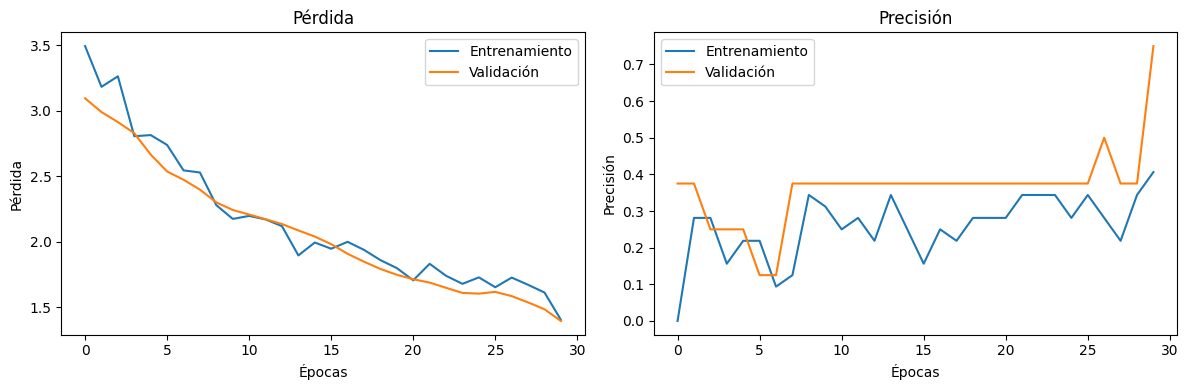

In [7]:
# Visualizar curvas de entrenamiento
def mostrar_curvas_entrenamiento(history):
    """Genera gráficos de pérdida y precisión para los datos de entrenamiento y validación."""
    # Extraer las métricas de la primera salida como ejemplo
    loss = history.history['char_0_loss']
    val_loss = history.history['val_char_0_loss']
    acc = history.history['char_0_accuracy']
    val_acc = history.history['val_char_0_accuracy']
    
    # Crear gráficos
    plt.figure(figsize=(12, 4))
    
    # Gráfico de pérdida
    plt.subplot(1, 2, 1)
    plt.plot(loss, label='Entrenamiento')
    plt.plot(val_loss, label='Validación')
    plt.title('Pérdida')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    
    # Gráfico de precisión
    plt.subplot(1, 2, 2)
    plt.plot(acc, label='Entrenamiento')
    plt.plot(val_acc, label='Validación')
    plt.title('Precisión')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()
    
    # Mostrar los gráficos
    plt.tight_layout()
    plt.show()

# Llamar a la función para mostrar las curvas de entrenamiento
mostrar_curvas_entrenamiento(history)

# Realizar Predicciones
Utilizar el modelo entrenado para predecir matrículas a partir de imágenes de prueba y comparar con las etiquetas reales.

In [ ]:
# Realizar predicciones con el modelo entrenado
n_samples = min(10, len(X_test))  # Número de muestras a predecir
indices = np.random.choice(len(X_test), n_samples, replace=False)  # Seleccionar índices aleatorios

for idx in indices:
    img = X_test[idx]  # Imagen de prueba
    true_label = ""  # Etiqueta real
    for i in range(MAX_LENGTH):
        true_idx = np.argmax(y_test[idx, i])  # Índice del carácter real
        true_label += INDEX_TO_CHAR[true_idx]  # Convertir índice a carácter

    # Realizar predicción
    img_batch = np.expand_dims(img, axis=0)  # Añadir dimensión de batch
    predictions = model.predict(img_batch)  # Predicción del modelo
    pred_label = ""  # Etiqueta predicha
    for pred in predictions:
        char_idx = np.argmax(pred[0])  # Índice del carácter predicho
        pred_label += INDEX_TO_CHAR[char_idx]  # Convertir índice a carácter

    # Mostrar resultados
    print(f"Real: {true_label}, Predicción: {pred_label}")